In [3]:
import pandas as pd
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, RobertaTokenizer, AutoModelForQuestionAnswering
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import wandb
from datasets import Dataset
import os
from collections import defaultdict
import numpy as np
from torch.utils.data import DataLoader
from transformers import AdamW
import evaluate
from transformers import default_data_collator
from transformers import Trainer
from tqdm.auto import tqdm
from transformers import TrainingArguments
from accelerate import Accelerator
from transformers import get_scheduler
# import gradio as gr
import re

os.environ["TOKENIZERS_PARALLELISM"] = "false"

tqdm.pandas()

In [2]:
pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
errorUuid = {"ad9271b7-9983-42f5-9bd9-fdfcb171ddaa":[[[4, 37],[4, 222]]]}
def parse_spoiler(x):
    spoiler = []
    if x['uuid'] in errorUuid:
        x['spoilerPositions'] = errorUuid[x['uuid']]

    for s in x['spoilerPositions']:
        st,en = s[0],s[1]
        spoiler.append(x['targetParagraphs'][st[0]][st[1]:en[1]])
        
    return spoiler

def findPosTags(x):    
    tokPos = []
    for pos in x['spoilerPositions']:
        st,en = pos
        idx = 0
        for i,p in enumerate([x['targetTitle']] + x['targetParagraphs']):
            if i==st[0]+1:
                start_ind = idx+st[1]
                end_ind = idx + en[1]
                
                tokPos.append([start_ind,end_ind])
                break
            if i==0:
                idx+=len(p)+3
            else:
                idx+=len(p)+1
        
    return tokPos

def read_prep(path,train=True):
    with open(path, 'rb') as json_file:
        json_list = list(json_file)

    results = []
    for json_str in json_list:
        result = json.loads(json_str)
        results.append(result)
    df = pd.DataFrame(results)
    df['tags'] = df.tags.apply(lambda x:x[0],1)
    df['postText'] = df.postText.apply(lambda x:x[0],1)    
    
    # Parsing for faulty spoiler ids
    df['spoilerParsed'] = df.apply(parse_spoiler,1)
    df['mergedParas'] = df['targetParagraphs'].apply(lambda x:" ".join(x),1)
    df.mergedParas = df.targetTitle + " - " + df.mergedParas
    df['tokPos'] = df.apply(findPosTags,1)
    df['label'] = df['tags'].map({"phrase":0,"passage":1,"multi":2})
    
    return df

In [5]:
df_train = read_prep("/kaggle/input/webisclickbait/webis-clickbait-22/train.jsonl")
df_valid = read_prep("/kaggle/input/webisclickbait/webis-clickbait-22/validation.jsonl")

In [6]:
def test_prep(path,train=True):
    with open(path, 'rb') as json_file:
        json_list = list(json_file)

    results = []
    for json_str in json_list:
        result = json.loads(json_str)
        results.append(result)
    df = pd.DataFrame(results)
    df['postText'] = df.postText.apply(lambda x:x[0],1)    
    
    # Parsing for faulty spoiler ids
    df['mergedParas'] = df['targetParagraphs'].apply(lambda x:" ".join(x),1)
    df.mergedParas = df.targetTitle + " - " + df.mergedParas
    
    return df

In [8]:
df_test = test_prep("/kaggle/input/skkonda/test.jsonl")

In [9]:
def convert2squadFormat(df):
    df_fin = df[['uuid','targetTitle','postText',"mergedParas","tokPos","spoiler"]]
    df_fin["asnwers"] = df_fin.apply(lambda x: {'text':x['spoiler'], "answer_start":[x['tokPos'][0][0]]},1)
    df_fin = df_fin.drop(columns=["tokPos","spoiler"])
    df_fin.columns = ["id","title","question","context","answers"]
    
    return df_fin


In [10]:
def test_convert2squadFormat(df):
    df_fin = df[['id','targetTitle','postText',"mergedParas"]]
    df_fin.columns = ["id","title","question","context"]
    
    return df_fin


In [11]:
pip install -U nltk


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [12]:
bleu = evaluate.load("bleu")
squad_metric = evaluate.load("squad")
meteor = evaluate.load('meteor')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [13]:
train_df = convert2squadFormat(df_train)
val_df = convert2squadFormat(df_valid)
test_df = test_convert2squadFormat(df_test)
train_data = Dataset.from_pandas(train_df.reset_index(drop=True), split="train")
val_data = Dataset.from_pandas(val_df.reset_index(drop=True), split="Val")
test_data = Dataset.from_pandas(test_df.reset_index(drop=True), split="test")


/tmp/ipykernel_28/1305749185.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fin["asnwers"] = df_fin.apply(lambda x: {'text':x['spoiler'], "answer_start":[x['tokPos'][0][0]]},1)
/tmp/ipykernel_28/1305749185.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fin["asnwers"] = df_fin.apply(lambda x: {'text':x['spoiler'], "answer_start":[x['tokPos'][0][0]]},1)


In [14]:
def preprocess_training_examples(examples):
    questions = examples['question']
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)
        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [15]:
def preprocess_validation_examples(examples):
    questions = examples["question"]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [16]:
def preprocess_test_examples(examples):
    questions = examples["question"]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [17]:

def compute_metrics(start_logits, end_logits, features, examples, predictOnly=False):
    example_to_features = defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_spoilers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        spoilers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]
            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    spoilers.append(answer)

        # Select the answer with the best score
        if len(spoilers) > 0:
            best_answer = max(spoilers, key=lambda x: x["logit_score"])
            predicted_spoilers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_spoilers.append({"id": example_id, "prediction_text": ""})
            
    predicted_texts = [i['prediction_text'] for i in predicted_spoilers]
    output = pd.DataFrame(predicted_spoilers)
    if predictOnly:
        return predicted_texts
    
    actual_spoilers_squad = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    actual_spoilers = [i['answers']['text'][0] for i in actual_spoilers_squad]    
    
    squad_metrics_eval = squad_metric.compute(predictions=predicted_spoilers, references=actual_spoilers_squad)
    bleu_eval = bleu.compute(predictions=predicted_texts, references=actual_spoilers)

    #Calculate the METEOR score using NLTK
    meteor_scores = meteor.compute(predictions=predicted_texts, references=actual_spoilers)

    return [squad_metrics_eval,bleu_eval],actual_spoilers,predicted_texts,meteor_scores


**BERT BASE MODEL**

In [18]:
model_name = "csarron/bert-base-uncased-squad-v1"



# Phrase Generation
config = dict(
max_length = 512,
stride = 128,
n_best = 25,
max_answer_length = 200,
batch_size = 8,
epochs = 5,
learning_rate = 1e-6,
model_name = model_name,
)


max_length = config["max_length"]
stride = config["stride"]
n_best = config["n_best"]
max_answer_length = config["max_answer_length"]



tokenizer = AutoTokenizer.from_pretrained(config["model_name"])
model = AutoModelForQuestionAnswering.from_pretrained(config["model_name"])

In [19]:
train_dataset = train_data.map(
    preprocess_training_examples,
    batched=True,
    remove_columns=train_data.column_names,
)

validation_dataset = val_data.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=val_data.column_names,
)

test_dataset = test_data.map(
    preprocess_test_examples,
    batched=True,
    remove_columns=test_data.column_names,
)

len(train_dataset), len(validation_dataset)

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

(6624, 1715)

In [20]:
from accelerate import Accelerator
train_dataset.set_format("torch")
validation_set = validation_dataset.remove_columns(["example_id", "offset_mapping"])
validation_set.set_format("torch")
test_set = test_dataset.remove_columns(["example_id", "offset_mapping"])
test_set.set_format("torch")

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=default_data_collator,
    batch_size=config["batch_size"],
)

eval_dataloader = DataLoader(
    validation_set, collate_fn=default_data_collator, batch_size=8 
)

test_dataloader = DataLoader(
    test_set, collate_fn=default_data_collator, batch_size=8 
)

optimizer = AdamW(model.parameters(), lr=config["learning_rate"])
accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader,test_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader ,test_dataloader
)

num_train_epochs = config["epochs"]
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
import io 
progress_bar = tqdm(range(num_training_steps))


all_metrics = []
max_bleu = 0.35
for epoch in range(num_train_epochs):
    # Training
    model.train()
    train_loss = 0
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)
        train_loss+=loss.item()
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    

    # Evaluation
    model.eval()
    start_logits = []
    end_logits = []
    accelerator.print("Evaluation!")
    
    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
        end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

    start_logits = np.concatenate(start_logits)
    end_logits = np.concatenate(end_logits)
    start_logits = start_logits[: len(validation_dataset)]
    end_logits = end_logits[: len(validation_dataset)]

    metrics,theoretical_texts,predicted_texts,meteor_scores = compute_metrics(
        start_logits, end_logits, validation_dataset, val_data
    )
    all_metrics.append(metrics)
    if metrics[1]['bleu']>max_bleu:
        model.save_pretrained(f"./models_task2_{spoiler_type}/")
        max_bleu = metrics[1]['bleu']
    print(f"epoch {epoch}:", meteor_scores)

  0%|          | 0/4140 [00:00<?, ?it/s]

Evaluation!


  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

epoch 0: {'meteor': 0.27938283885297244}
Evaluation!


  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

epoch 1: {'meteor': 0.32148308994772834}
Evaluation!


  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

epoch 2: {'meteor': 0.33294349990344185}
Evaluation!


  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

epoch 3: {'meteor': 0.34126071587533074}
Evaluation!


  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

epoch 4: {'meteor': 0.33900894154535954}


In [23]:

def compute_test_metrics(start_logits, end_logits, features, examples, predictOnly=False):
    example_to_features = defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_spoilers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        spoilers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]
            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    spoilers.append(answer)

        # Select the answer with the best score
        if len(spoilers) > 0:
            best_answer = max(spoilers, key=lambda x: x["logit_score"])
            predicted_spoilers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_spoilers.append({"id": example_id, "prediction_text": ""})
            
    predicted_texts = [i['prediction_text'] for i in predicted_spoilers]
    output = pd.DataFrame(predicted_spoilers)


    return output


In [24]:
 # Evaluation
model.eval()
start_logits = []
end_logits = []
accelerator.print("Evaluation!")
    
for batch in tqdm(test_dataloader):
    with torch.no_grad():
        outputs = model(**batch)

    start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
    end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

start_logits = np.concatenate(start_logits)
end_logits = np.concatenate(end_logits)
start_logits = start_logits[: len(validation_dataset)]
end_logits = end_logits[: len(validation_dataset)]

Outputs = compute_test_metrics(
        start_logits, end_logits, test_dataset, test_data
    )

Evaluation!


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [25]:
from IPython.display import FileLink
Outputs.to_csv('output_generation_bert.csv', index=False)
# Display a link to download the CSV file
FileLink("output_generation_bert.csv")

/kaggle/working/output_generation_bert.csv

In [26]:
dfs_list = []

# Loop through your data, assuming 'data_list' contains the individual DataFrames
for data in range(len(all_metrics)):
    # Process each data to create a DataFrame (if needed)
    df = pd.DataFrame(all_metrics[data][0],index=[0])
    # Append the DataFrame to the list
    dfs_list.append(df)

# Concatenate the DataFrames along the rows (axis=0)
resulting_dataframe_bert = pd.concat(dfs_list, axis=0)

In [27]:
resulting_dataframe_bert

,exact_match,f1
0,19.250,32.146824
0,22.375,36.899474
0,23.875,38.134731
0,25.500,39.670654
0,25.375,39.423831


In [28]:
dfs_list = []

# Loop through your data, assuming 'all_metrics' contains the individual DataFrames
for data in range(len(all_metrics)):
    # Create a DataFrame from the dictionary element
    
    # Calculate the maximum value from the 'precisions' list
    all_metrics[data][1]['precisions'] = np.max(all_metrics[data][1]['precisions'])
    
    df = pd.DataFrame(all_metrics[data][1],index=[0])
    
    # Append the DataFrame to the list
    dfs_list.append(df)
resulting_dataframe_belu = pd.concat(dfs_list, ignore_index=True)

In [29]:
resulting_dataframe_belu

,bleu,precisions,brevity_penalty,length_ratio,translation_length,reference_length
0,0.116693,0.176218,1.0,1.344157,12791,9516
1,0.137218,0.200337,1.0,1.372741,13063,9516
2,0.141971,0.203272,1.0,1.393758,13263,9516
3,0.154689,0.220460,1.0,1.278899,12170,9516
4,0.150756,0.216265,1.0,1.289617,12272,9516


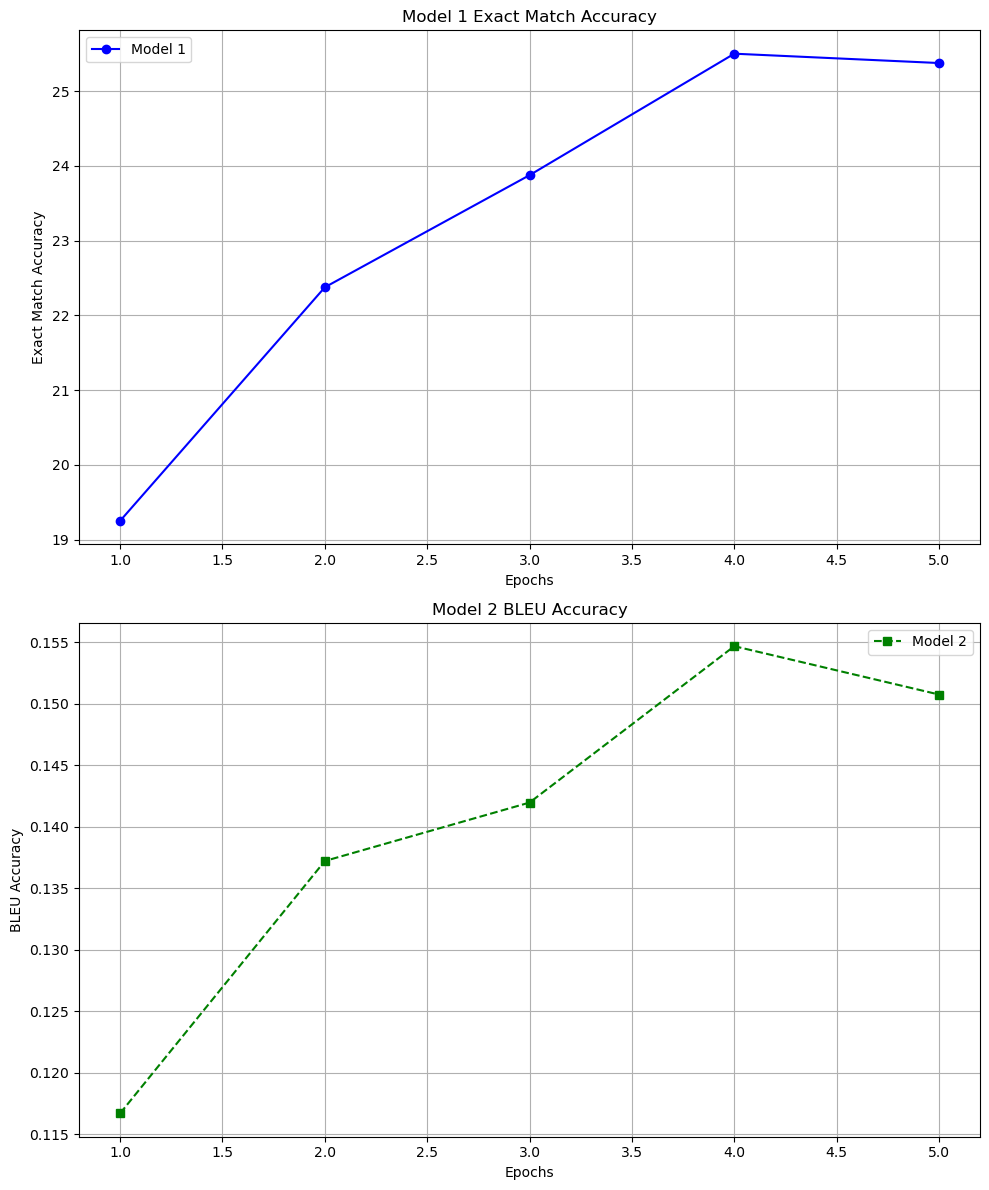

In [30]:
import matplotlib.pyplot as plt

# Sample data for accuracy
epochs = [1, 2, 3, 4, 5]



# Create subplots with 2 rows and 1 column
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Plot Model 1 accuracy on the first subplot
axs[0].plot(epochs, resulting_dataframe_bert['exact_match'], label='Model 1', marker='o', linestyle='-', color='blue')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Exact Match Accuracy')
axs[0].set_title('Model 1 Exact Match Accuracy')
axs[0].grid(True)
axs[0].legend()

# Plot Model 2 accuracy on the second subplot
axs[1].plot(epochs, resulting_dataframe_belu['bleu'], label='Model 2', marker='s', linestyle='--', color='green')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('BLEU Accuracy')
axs[1].set_title('Model 2 BLEU Accuracy')
axs[1].grid(True)
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()


**DEBERTA BASE MODEL**

In [31]:

model_name = "deepset/deberta-v3-base-squad2"






config = dict(
max_length = 512,
stride = 128,
n_best = 25,
max_answer_length = 200,
batch_size = 8,
epochs = 5,
learning_rate = 1e-6,
model_name = model_name,
)


max_length = config["max_length"]
stride = config["stride"]
n_best = config["n_best"]
max_answer_length = config["max_answer_length"]



tokenizer_minilm = AutoTokenizer.from_pretrained(config["model_name"])
model_minilm = AutoModelForQuestionAnswering.from_pretrained(config["model_name"])

In [32]:
def preprocess_training_examples(examples):
    questions = examples['question']
    inputs = tokenizer_minilm(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)
        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [34]:
def preprocess_validation_examples(examples):
    questions = examples["question"]
    inputs = tokenizer_minilm(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [35]:
def preprocess_test_examples(examples):
    questions = examples["question"]
    inputs = tokenizer_minilm(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [36]:
train_dataset = train_data.map(
    preprocess_training_examples,
    batched=True,
    remove_columns=train_data.column_names,
)

validation_dataset = val_data.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=val_data.column_names,
)

test_dataset = test_data.map(
    preprocess_test_examples,
    batched=True,
    remove_columns=test_data.column_names,
)

len(train_dataset), len(validation_dataset)

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

(6419, 1664)

In [37]:
from accelerate import Accelerator
train_dataset.set_format("torch")
validation_set = validation_dataset.remove_columns(["example_id", "offset_mapping"])
validation_set.set_format("torch")
test_set = test_dataset.remove_columns(["example_id", "offset_mapping"])
test_set.set_format("torch")

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=default_data_collator,
    batch_size=config["batch_size"],
)

eval_dataloader = DataLoader(
    validation_set, collate_fn=default_data_collator, batch_size=8 
)

test_dataloader = DataLoader(
    test_set, collate_fn=default_data_collator, batch_size=8 
)

optimizer = AdamW(model_minilm.parameters(), lr=config["learning_rate"])
accelerator = Accelerator()
model_minilm, optimizer, train_dataloader, eval_dataloader,test_dataloader = accelerator.prepare(
    model_minilm, optimizer, train_dataloader, eval_dataloader ,test_dataloader
)

num_train_epochs = config["epochs"]
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [38]:
import io 
progress_bar = tqdm(range(num_training_steps))


all_metrics = []
max_bleu = 0.35
for epoch in range(num_train_epochs):
    # Training
    model_minilm.train()
    train_loss = 0
    for step, batch in enumerate(train_dataloader):
        outputs = model_minilm(**batch)
        loss = outputs.loss
        accelerator.backward(loss)
        train_loss+=loss.item()
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    

    # Evaluation
    model_minilm.eval()
    start_logits = []
    end_logits = []
    accelerator.print("Evaluation!")
    
    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            outputs = model_minilm(**batch)

        start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
        end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

    start_logits = np.concatenate(start_logits)
    end_logits = np.concatenate(end_logits)
    start_logits = start_logits[: len(validation_dataset)]
    end_logits = end_logits[: len(validation_dataset)]

    metrics,theoretical_texts,predicted_texts,meteor_scores = compute_metrics(
        start_logits, end_logits, validation_dataset, val_data
    )
    all_metrics.append(metrics)
    if metrics[1]['bleu']>max_bleu:
        model.save_pretrained(f"./models_task2_{spoiler_type}/")
        max_bleu = metrics[1]['bleu']
    print(f"epoch {epoch}:", meteor_scores)

  0%|          | 0/4015 [00:00<?, ?it/s]

Evaluation!


  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

epoch 0: {'meteor': 0.32761105734701895}
Evaluation!


  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

epoch 1: {'meteor': 0.38458872855520987}
Evaluation!


  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

epoch 2: {'meteor': 0.41253035800196797}
Evaluation!


  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

epoch 3: {'meteor': 0.42888250801487443}
Evaluation!


  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

epoch 4: {'meteor': 0.4282884056240573}


In [39]:
 # Evaluation
model_minilm.eval()
start_logits = []
end_logits = []
accelerator.print("Evaluation!")
    
for batch in tqdm(test_dataloader):
    with torch.no_grad():
        outputs = model_minilm(**batch)

    start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
    end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

start_logits = np.concatenate(start_logits)
end_logits = np.concatenate(end_logits)
start_logits = start_logits[: len(validation_dataset)]
end_logits = end_logits[: len(validation_dataset)]

Outputs = compute_test_metrics(
        start_logits, end_logits, test_dataset, test_data
    )

Evaluation!


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [40]:
from IPython.display import FileLink
Outputs.to_csv('output_generation_deb.csv', index=False)
# Display a link to download the CSV file
FileLink("output_generation_deb.csv")

/kaggle/working/output_generation_deb.csv

In [41]:
dfs_list = []

# Loop through your data, assuming 'data_list' contains the individual DataFrames
for data in range(len(all_metrics)):
    # Process each data to create a DataFrame (if needed)
    df = pd.DataFrame(all_metrics[data][0],index=[0])
    # Append the DataFrame to the list
    dfs_list.append(df)

# Concatenate the DataFrames along the rows (axis=0)
resulting_dataframe_minilim_Em = pd.concat(dfs_list, axis=0)

In [42]:
resulting_dataframe_minilim_Em

,exact_match,f1
0,19.000,34.723194
0,23.625,41.191441
0,27.250,44.878613
0,29.500,47.201117
0,30.250,47.499354


In [43]:
dfs_list = []

# Loop through your data, assuming 'all_metrics' contains the individual DataFrames
for data in range(len(all_metrics)):
    # Create a DataFrame from the dictionary element
    
    # Calculate the maximum value from the 'precisions' list
    all_metrics[data][1]['precisions'] = np.max(all_metrics[data][1]['precisions'])
    
    df = pd.DataFrame(all_metrics[data][1],index=[0])
    
    # Append the DataFrame to the list
    dfs_list.append(df)
resulting_dataframe_minilim_Belu = pd.concat(dfs_list, ignore_index=True)

In [44]:
resulting_dataframe_minilim_Belu

,bleu,precisions,brevity_penalty,length_ratio,translation_length,reference_length
0,0.106347,0.161079,1.0,1.796028,17091,9516
1,0.143823,0.204842,1.0,1.619063,15407,9516
2,0.167111,0.231628,1.0,1.525746,14519,9516
3,0.180880,0.248605,1.0,1.412253,13439,9516
4,0.185374,0.250596,1.0,1.365805,12997,9516


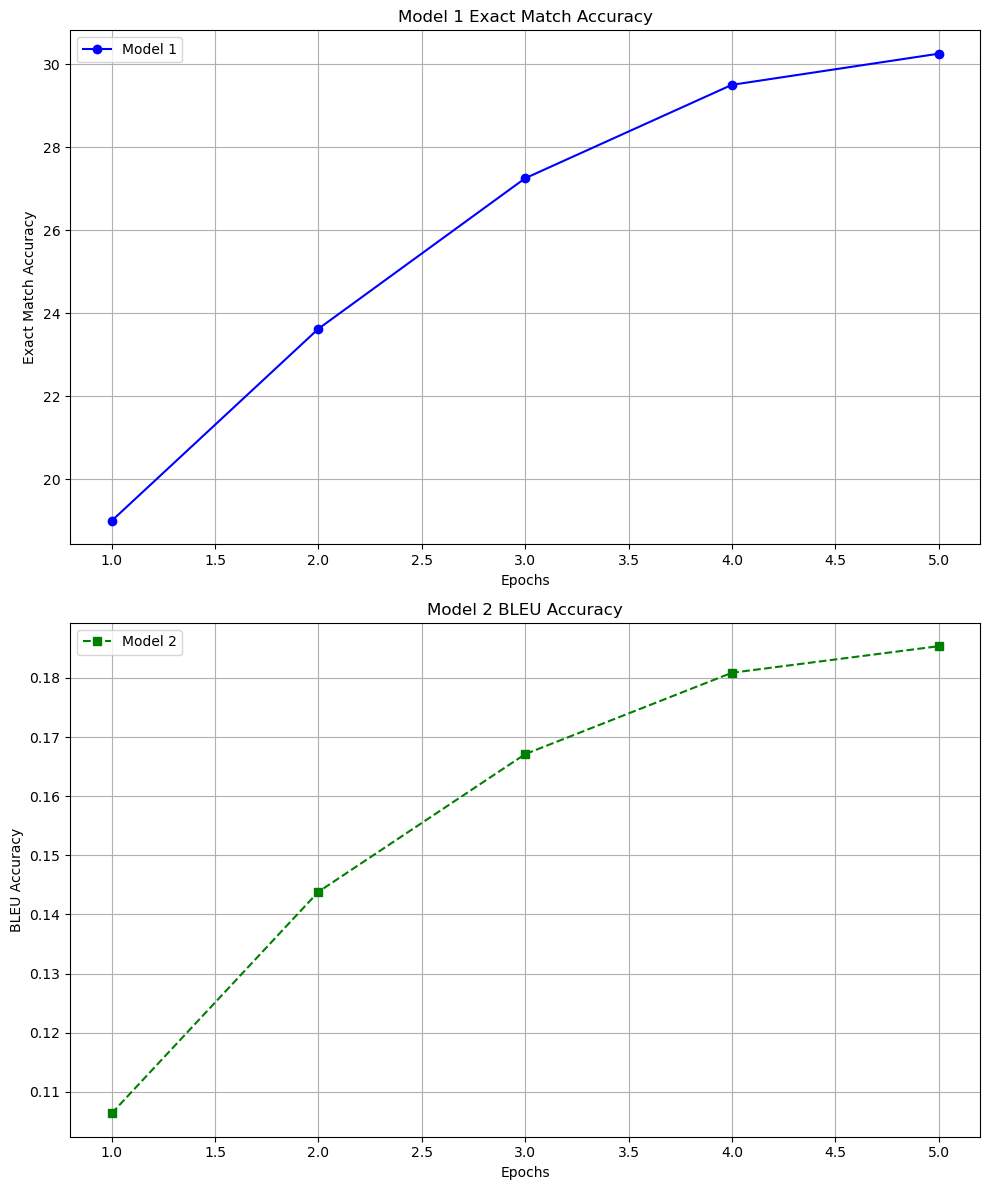

In [45]:
import matplotlib.pyplot as plt

# Sample data for accuracy
epochs = [1, 2, 3, 4, 5]



# Create subplots with 2 rows and 1 column
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Plot Model 1 accuracy on the first subplot
axs[0].plot(epochs, resulting_dataframe_minilim_Em['exact_match'], label='Model 1', marker='o', linestyle='-', color='blue')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Exact Match Accuracy')
axs[0].set_title('Model 1 Exact Match Accuracy')
axs[0].grid(True)
axs[0].legend()

# Plot Model 2 accuracy on the second subplot
axs[1].plot(epochs, resulting_dataframe_minilim_Belu['bleu'], label='Model 2', marker='s', linestyle='--', color='green')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('BLEU Accuracy')
axs[1].set_title('Model 2 BLEU Accuracy')
axs[1].grid(True)
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()


**ROBERTA BASE MODEL**

In [46]:


model_name = "deepset/roberta-base-squad2"




config = dict(
max_length = 512,
stride = 128,
n_best = 25,
max_answer_length = 200,
batch_size = 4,
epochs = 5,
learning_rate = 1e-6,
model_name = model_name,
)


max_length = config["max_length"]
stride = config["stride"]
n_best = config["n_best"]
max_answer_length = config["max_answer_length"]



tokenizer_roberta = AutoTokenizer.from_pretrained(config["model_name"])
model_roberta = AutoModelForQuestionAnswering.from_pretrained(config["model_name"])

In [47]:
def preprocess_training_examples(examples):
    questions = examples['question']
    inputs = tokenizer_roberta(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)
        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [48]:
def preprocess_validation_examples(examples):
    questions = examples["question"]
    inputs = tokenizer_roberta(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [49]:
def preprocess_test_examples(examples):
    questions = examples["question"]
    inputs = tokenizer_roberta(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [50]:
train_dataset = train_data.map(
    preprocess_training_examples,
    batched=True,
    remove_columns=train_data.column_names,
)

validation_dataset = val_data.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=val_data.column_names,
)

test_dataset = test_data.map(
    preprocess_test_examples,
    batched=True,
    remove_columns=test_data.column_names,
)

len(train_dataset), len(validation_dataset)

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

(6579, 1712)

In [51]:
from accelerate import Accelerator
train_dataset.set_format("torch")
validation_set = validation_dataset.remove_columns(["example_id", "offset_mapping"])
validation_set.set_format("torch")
test_set = test_dataset.remove_columns(["example_id", "offset_mapping"])
test_set.set_format("torch")

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=default_data_collator,
    batch_size=config["batch_size"],
)

eval_dataloader = DataLoader(
    validation_set, collate_fn=default_data_collator, batch_size=4
)

test_dataloader = DataLoader(
    test_set, collate_fn=default_data_collator, batch_size=4
)

optimizer = AdamW(model_roberta.parameters(), lr=config["learning_rate"])
accelerator = Accelerator()
model_roberta, optimizer, train_dataloader, eval_dataloader,test_dataloader = accelerator.prepare(
    model_roberta, optimizer, train_dataloader, eval_dataloader ,test_dataloader
)

num_train_epochs = config["epochs"]
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [52]:
import io 
progress_bar = tqdm(range(num_training_steps))


all_metrics = []
max_bleu = 0.35
for epoch in range(num_train_epochs):
    # Training
    model_roberta.train()
    train_loss = 0
    for step, batch in enumerate(train_dataloader):
        outputs = model_roberta(**batch)
        loss = outputs.loss
        accelerator.backward(loss)
        train_loss+=loss.item()
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    

    # Evaluation
    model_roberta.eval()
    start_logits = []
    end_logits = []
    accelerator.print("Evaluation!")
    
    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            outputs = model_roberta(**batch)

        start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
        end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

    start_logits = np.concatenate(start_logits)
    end_logits = np.concatenate(end_logits)
    start_logits = start_logits[: len(validation_dataset)]
    end_logits = end_logits[: len(validation_dataset)]

    metrics,theoretical_texts,predicted_texts,meteor_scores = compute_metrics(
        start_logits, end_logits, validation_dataset, val_data
    )
    all_metrics.append(metrics)
    if metrics[1]['bleu']>max_bleu:
        model.save_pretrained(f"./models_task2_{spoiler_type}/")
        max_bleu = metrics[1]['bleu']
    print(f"epoch {epoch}:", meteor_scores)

  0%|          | 0/8225 [00:00<?, ?it/s]

Evaluation!


  0%|          | 0/428 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

epoch 0: {'meteor': 0.4198634636189132}
Evaluation!


  0%|          | 0/428 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

epoch 1: {'meteor': 0.44387856443366497}
Evaluation!


  0%|          | 0/428 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

epoch 2: {'meteor': 0.45255722926769465}
Evaluation!


  0%|          | 0/428 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

epoch 3: {'meteor': 0.4604493912231453}
Evaluation!


  0%|          | 0/428 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

epoch 4: {'meteor': 0.46111550033058607}


In [53]:
 # Evaluation
model_roberta.eval()
start_logits = []
end_logits = []
accelerator.print("Evaluation!")
    
for batch in tqdm(test_dataloader):
    with torch.no_grad():
        outputs = model_roberta(**batch)

    start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
    end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

start_logits = np.concatenate(start_logits)
end_logits = np.concatenate(end_logits)
start_logits = start_logits[: len(validation_dataset)]
end_logits = end_logits[: len(validation_dataset)]

Outputs = compute_test_metrics(
        start_logits, end_logits, test_dataset, test_data
    )

Evaluation!


  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [54]:
from IPython.display import FileLink
Outputs.to_csv('output_generation_Roberta.csv', index=False)
# Display a link to download the CSV file
FileLink("output_generation_Roberta.csv")

/kaggle/working/output_generation_Roberta.csv

In [56]:
dfs_list = []

# Loop through your data, assuming 'data_list' contains the individual DataFrames
for data in range(len(all_metrics)):
    # Process each data to create a DataFrame (if needed)
    df = pd.DataFrame(all_metrics[data][0],index=[0])
    # Append the DataFrame to the list
    dfs_list.append(df)

# Concatenate the DataFrames along the rows (axis=0)
resulting_dataframe_roberta_Em = pd.concat(dfs_list, axis=0)

In [57]:
resulting_dataframe_roberta_Em

,exact_match,f1
0,31.000,48.284591
0,33.750,50.903531
0,35.125,52.335638
0,35.625,52.682807
0,35.500,52.824439


In [58]:
dfs_list = []

# Loop through your data, assuming 'all_metrics' contains the individual DataFrames
for data in range(len(all_metrics)):
    # Create a DataFrame from the dictionary element
    
    # Calculate the maximum value from the 'precisions' list
    all_metrics[data][1]['precisions'] = np.max(all_metrics[data][1]['precisions'])
    
    df = pd.DataFrame(all_metrics[data][1],index=[0])
    
    # Append the DataFrame to the list
    dfs_list.append(df)
resulting_dataframe_roberta_Belu = pd.concat(dfs_list, ignore_index=True)

In [59]:
resulting_dataframe_roberta_Belu

,bleu,precisions,brevity_penalty,length_ratio,translation_length,reference_length
0,0.180655,0.252592,1.0,1.297604,12348,9516
1,0.206165,0.277368,1.0,1.253678,11930,9516
2,0.224407,0.297466,1.0,1.161202,11050,9516
3,0.235530,0.307551,1.0,1.146700,10912,9516
4,0.249578,0.324066,1.0,1.088588,10359,9516


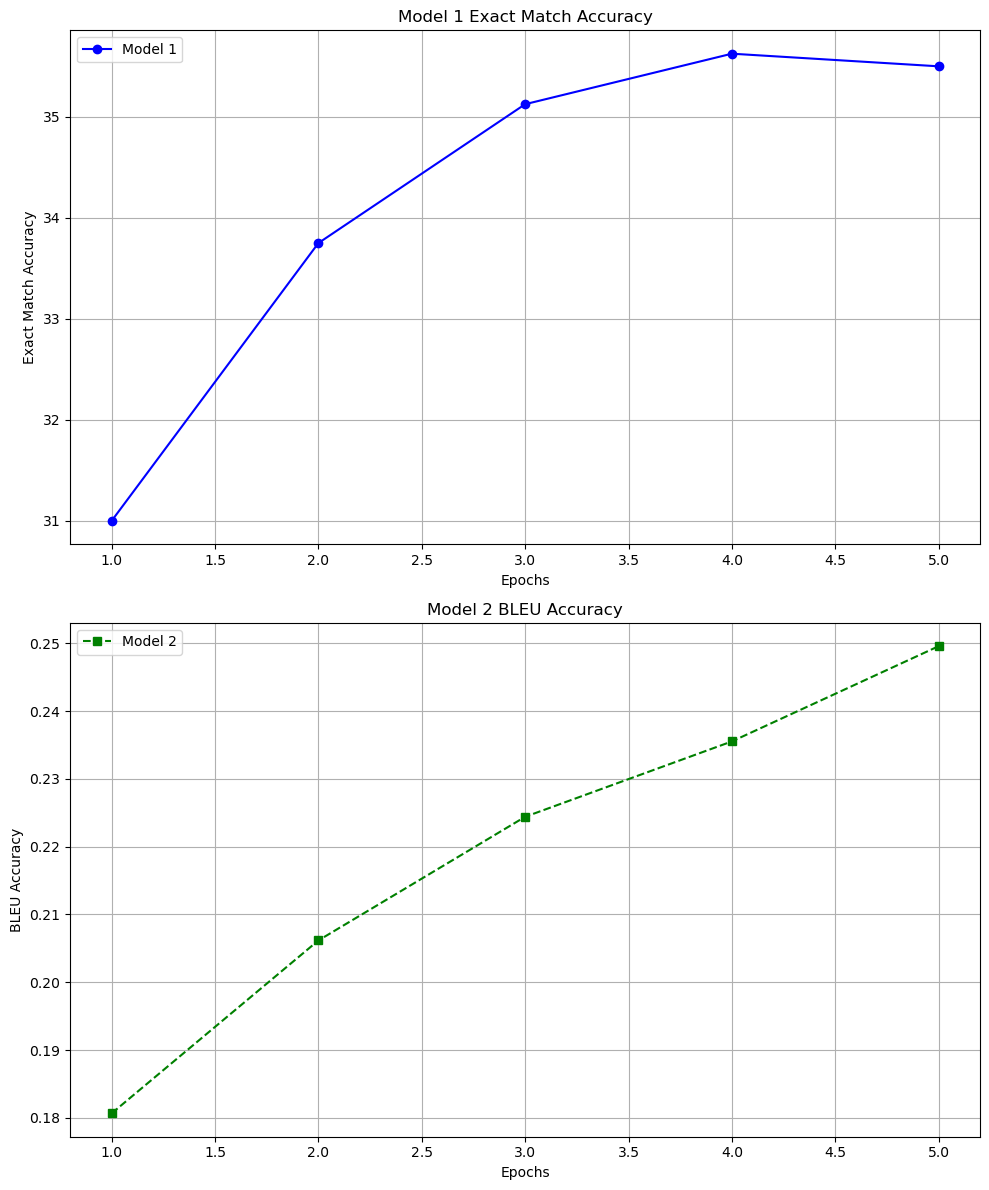

In [60]:
import matplotlib.pyplot as plt

# Sample data for accuracy
epochs = [1, 2, 3, 4, 5]



# Create subplots with 2 rows and 1 column
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Plot Model 1 accuracy on the first subplot
axs[0].plot(epochs, resulting_dataframe_roberta_Em['exact_match'], label='Model 1', marker='o', linestyle='-', color='blue')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Exact Match Accuracy')
axs[0].set_title('Model 1 Exact Match Accuracy')
axs[0].grid(True)
axs[0].legend()

# Plot Model 2 accuracy on the second subplot
axs[1].plot(epochs, resulting_dataframe_roberta_Belu['bleu'], label='Model 2', marker='s', linestyle='--', color='green')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('BLEU Accuracy')
axs[1].set_title('Model 2 BLEU Accuracy')
axs[1].grid(True)
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()


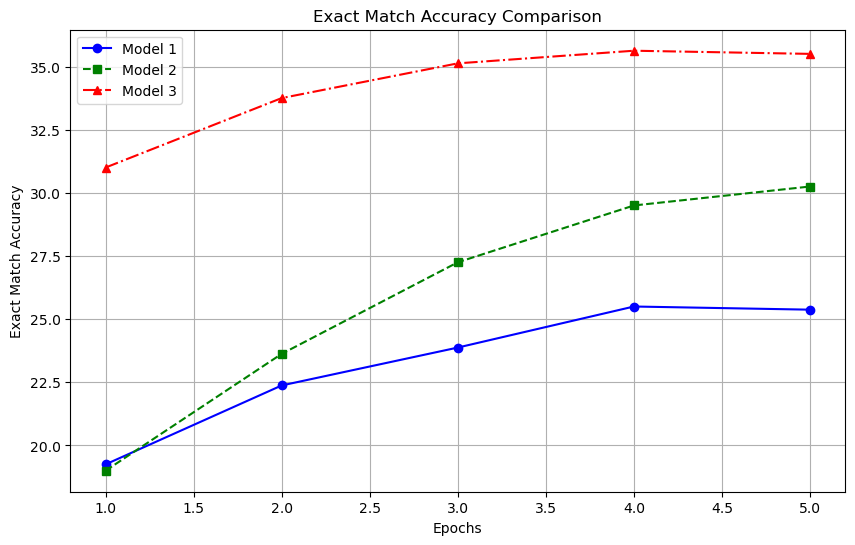

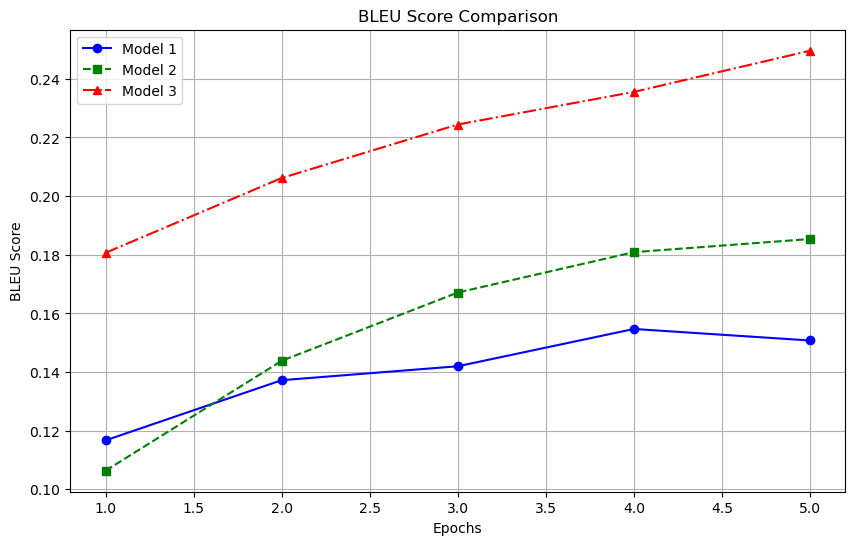

In [62]:
import matplotlib.pyplot as plt

# Sample data for accuracy
epochs = [1, 2, 3, 4, 5]


# Create a plot for EM accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, resulting_dataframe_bert['exact_match'], label='Model 1', marker='o', linestyle='-', color='blue')
plt.plot(epochs, resulting_dataframe_minilim_Em['exact_match'], label='Model 2', marker='s', linestyle='--', color='green')
plt.plot(epochs, resulting_dataframe_roberta_Em['exact_match'], label='Model 3', marker='^', linestyle='-.', color='red')
plt.xlabel('Epochs')
plt.ylabel('Exact Match Accuracy')
plt.title('Exact Match Accuracy Comparison')
plt.grid(True)
plt.legend()

# Show the EM accuracy plot
plt.show()

# Create a plot for BLEU scores
plt.figure(figsize=(10, 6))
plt.plot(epochs, resulting_dataframe_belu['bleu'], label='Model 1', marker='o', linestyle='-', color='blue')
plt.plot(epochs, resulting_dataframe_minilim_Belu['bleu'], label='Model 2', marker='s', linestyle='--', color='green')
plt.plot(epochs, resulting_dataframe_roberta_Belu['bleu'], label='Model 3', marker='^', linestyle='-.', color='red')
plt.xlabel('Epochs')
plt.ylabel('BLEU Score')
plt.title('BLEU Score Comparison')
plt.grid(True)
plt.legend()

# Show the BLEU score plot
plt.show()


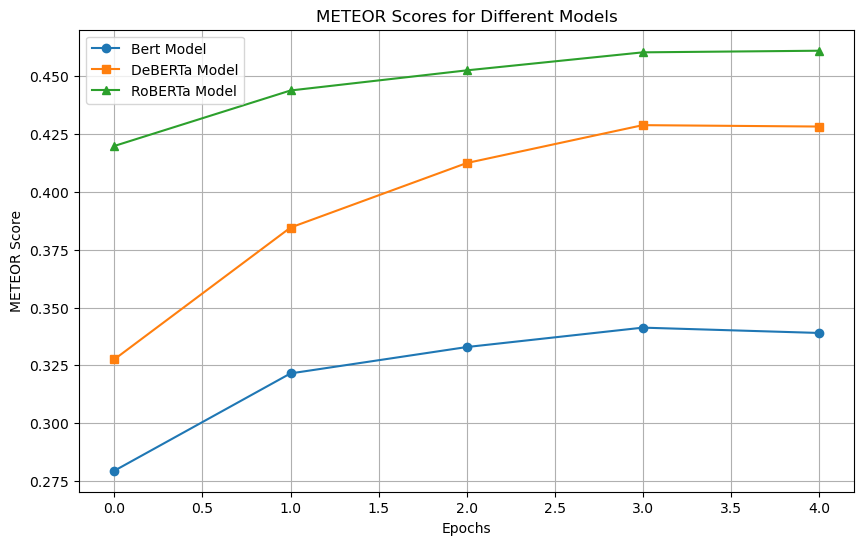

In [2]:
import matplotlib.pyplot as plt

epochs = [0, 1, 2, 3, 4]

# METEOR scores for each model
bert_scores = [0.2794, 0.3215, 0.3329, 0.3413, 0.3390]
deberta_scores = [0.3276, 0.3846, 0.4125, 0.4289, 0.4283]
roberta_scores = [0.4199, 0.4439, 0.4526, 0.4604, 0.4611]

# Plotting the METEOR scores for each model
plt.figure(figsize=(10, 6))
plt.plot(epochs, bert_scores, marker='o', label='Bert Model')
plt.plot(epochs, deberta_scores, marker='s', label='DeBERTa Model')
plt.plot(epochs, roberta_scores, marker='^', label='RoBERTa Model')

plt.xlabel('Epochs')
plt.ylabel('METEOR Score')
plt.title('METEOR Scores for Different Models')
plt.legend()
plt.grid(True)
plt.show()
